## Cài đặt các thư viện cần thiết

In [1]:
! pip install underthesea --quiet
! pip install gdown --quiet
! pip install sacrebleu --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 8.6 MB/s eta 0:00:00


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hungnm/englishvietnamese-translation")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/englishvietnamese-translation


In [3]:
import os
import io
import time
import json
import pickle
import numpy as np
import tensorflow as tf
from keras.metrics import Mean
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from underthesea import word_tokenize
from keras.utils import pad_sequences
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.text import tokenizer_from_json, Tokenizer

In [4]:
ENCODER_LEN = 100 # max length of encoder input
DECODER_LEN = 100 # max length of decoder input
BATCH_SIZE = 64 # batch size
BUFFER_SIZE = BATCH_SIZE * 8 # buffer size for shuffling

## Load dữ liệu và tiền xử lý

In [5]:
en_file_path = os.path.join(path, "en_sents")
vi_file_path = os.path.join(path, "vi_sents")

with open(en_file_path, "r", encoding="utf-8") as f_en, \
        open(vi_file_path, "r", encoding="utf-8") as f_vi:
    en_lines = f_en.read().splitlines()
    vi_lines = f_vi.read().splitlines()

In [6]:
print(f"Number of English sentences: {len(en_lines)}")
print(f"Number of Vietnamese sentences: {len(vi_lines)}")

Number of English sentences: 254090
Number of Vietnamese sentences: 254090


In [7]:
train_size = int(0.8 * len(en_lines))
val_size = int(0.1 * len(en_lines))
test_size = len(en_lines) - train_size - val_size

train_data = {"en": en_lines[:train_size], "vi": vi_lines[:train_size]}
val_data = {"en": en_lines[train_size:train_size + val_size], "vi": vi_lines[train_size:train_size + val_size]}
test_data = {"en": en_lines[train_size + val_size:], "vi": vi_lines[train_size + val_size:]}

In [8]:
print(f"Number of English sentences: {len(train_data['en'])}")
print(f"Number of Vietnamese sentences: {len(train_data['vi'])}")

Number of English sentences: 203272
Number of Vietnamese sentences: 203272


In [9]:
train_data["en"][:3]

['Please put the dustpan in the broom closet',
 'Be quiet for a moment.',
 'Read this']

In [10]:
train_data["vi"][:3]

['xin vui lòng đặt người quét rác trong tủ chổi', 'im lặng một lát', 'đọc này']

In [11]:
def preprocess_texts(texts, is_vietnamese=True):
    if isinstance(texts, str):
        texts = [texts]

    tokenized_texts = []
    for text in texts:
        if is_vietnamese:
            tokens = word_tokenize(text.lower().strip())
        else:
            tokens = text.lower().strip().split()
        tokens.insert(0, "startseq")
        tokens.append("endseq")
        tokenized_texts.append(" ".join(tokens))
    return tokenized_texts

In [12]:
# Preprocess and tokenize
preprocessed_en = preprocess_texts(train_data["en"], is_vietnamese=False)
preprocessed_vi = preprocess_texts(train_data["vi"], is_vietnamese=True)

filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'

oov_token = '<Unknow>'

en_tokenizer = Tokenizer(filters=filters, oov_token=oov_token)
vi_tokenizer = Tokenizer(filters=filters, oov_token=oov_token)

In [13]:
en_tokenizer.fit_on_texts(preprocessed_en)
vi_tokenizer.fit_on_texts(preprocessed_vi)

In [14]:
inputs = en_tokenizer.texts_to_sequences(preprocessed_en)
targets = vi_tokenizer.texts_to_sequences(preprocessed_vi)

In [15]:
inputs = pad_sequences(
    inputs,
    maxlen=ENCODER_LEN,
    padding='post',
    truncating='post'
)

targets = pad_sequences(
    targets,
    maxlen=DECODER_LEN,
    padding='post',
    truncating='post'
)
inputs = tf.cast(inputs, dtype=tf.int64)
targets = tf.cast(targets, dtype=tf.int64)

In [16]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [17]:
print(len(en_tokenizer.word_index) + 1, len(vi_tokenizer.word_index) + 1)

19245 6477


In [18]:
print(vi_tokenizer.word_index.get('startseq'))

2


## Các thành phần của Transformer

In [19]:
# Hàm tính góc cho vào positional i, d_model là số chiều của vector
# Là tính góc cho các sin, cos của các từ cho dễ tính toán
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates


def positional_encoding(position, d_model):
    # tính góc cho các từ
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    # tính sin cho các từ ở vị trí chẵn
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # tính cos cho các từ ở vị trí lẻ
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]


    return tf.cast(pos_encoding, dtype=tf.float32)

In [20]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [21]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [22]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

### Multi head Attention

In [23]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads): # Khởi tạo một multi-head attention
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        return output, attention_weights

In [24]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

### Lớp Encoder Layer

In [25]:
class EncoderLayer(tf.keras.layers.Layer): # Lớp Encoder Layer
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

### Lớp Decoder Layer

In [26]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

### Khối Encoder

In [27]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=mask)

        return x

### Khối Decoder

In [28]:
class Decoder(tf.keras.layers.Layer):

    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](
                x,
                enc_output,
                training=training,
                look_ahead_mask=look_ahead_mask,
                padding_mask=padding_mask
            )


            attention_weights['decoder_layer{}_block1'.format(i + 1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i + 1)] = block2

        return x, attention_weights

### Mô hình Transformer

In [29]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size,
                 pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(
            inp,
            training=training,
            mask=enc_padding_mask
        )

        dec_output, attention_weights = self.decoder(
            tar,
            enc_output,
            training=training,
            look_ahead_mask=look_ahead_mask,
            padding_mask=dec_padding_mask
        )

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [30]:
num_layers = 6 # number of layers của encoder và decoder hay là số khối encoder và decoder
d_model = 128 # Dim của vector đầu ra của mỗi layer trong encoder và decoder
dff = 512 # Dim của feed forward network
num_heads = 4 # Số head trong multi-head attention
dropout_rate = 0.15 # Tỷ lệ dropout
EPOCHS = 15 # Số epoch

### Set up the optimizer

Learning rate được tính theo công thức sau:
$lrate = d_{model}^{-0.5} * min(\text{step_num}^{-0.5}, \text{step_num}.\text{warmup_step}^{-1.5}) $

In [31]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

### Sử dụng Adam optimizer với custom learning rate

In [32]:
temp_learning_rate_schedule = CustomSchedule(d_model)
learning_rate = CustomSchedule(d_model)
optimizer = Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

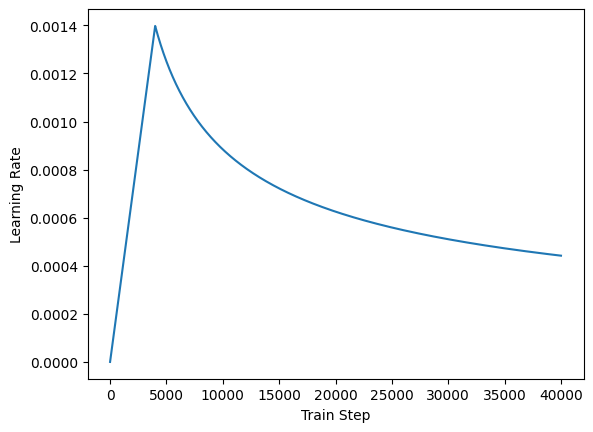

In [33]:
plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

In [34]:
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies) / tf.reduce_sum(mask)

In [35]:
train_loss = Mean(name='train_loss')
train_accuracy = Mean(name='train_accuracy')

In [36]:
with tf.device('/GPU:0'):
    transformer = Transformer(
        num_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        dff=dff,
        input_vocab_size=len(en_tokenizer.word_index) + 1,
        target_vocab_size=len(vi_tokenizer.word_index) + 1,
        pe_input=inputs.shape[1],
        pe_target=targets.shape[1],
        rate=dropout_rate
    )

In [37]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)  # Encoder padding mask
    dec_padding_mask = create_padding_mask(inp)  # Decoder padding mask

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])  # Decoder look ahead mask
    dec_target_padding_mask = create_padding_mask(tar)  # Decoder target padding mask
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)  # Cộng hai mask lại với nhau

    return enc_padding_mask, combined_mask, dec_padding_mask  # Trả về các mask

Sử dụng checkpoint manager để lưu lại trạng thái của mô hình sau các epoch

In [38]:
checkpoint_path = "checkpoints"  # Đường dẫn lưu checkpoint
check_point_exists = False  # Biến kiểm tra checkpoint đã tồn tại hay chưa

ckpt = tf.train.Checkpoint(
    transformer=transformer,
    optimizer=optimizer
)  # Tạo checkpoint

ckpt_manager = tf.train.CheckpointManager(
    ckpt,
    checkpoint_path,
    max_to_keep=5 # Số lượng checkpoint lớn nhất được lưu lại
)  # Tạo checkpoint manager

if ckpt_manager.latest_checkpoint:  # Nếu trong thư mục có checkpoint
    ckpt.restore(ckpt_manager.latest_checkpoint)  # Restore checkpoint mới nhất
    check_point_exists = True
    print("Đã load checkpoint")  # In ra đã restore checkpoint

In [39]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    # Tạo các mask
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        # Gọi mô hình với keyword arguments
        predictions, _ = transformer(
            inp,
            tar_inp,
            training=True,
            enc_padding_mask=enc_padding_mask,
            look_ahead_mask=combined_mask,
            dec_padding_mask=dec_padding_mask
        )

        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))


# Training the Model

In [ ]:
# Ở đây tôi muốn nếu có checkpoint rồi thì chỉ cần sửa và không train thêm nữa
if check_point_exists:  # Nếu chưa có checkpoint
    EPOCHS = 0  # Số epoch /Nếu muốn train tiếp tục thì gán giá trị cho biến này

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()  # Lấy thời gian bắt đầu train

    train_loss.reset_state()  # Reset loss
    train_accuracy.reset_state()  # Reset accuracy

    for (batch, (inp, tar)) in enumerate(dataset):  # Lặp qua các batch dữ liệu
        train_step(inp, tar)  # Train mô hình

        if batch % 1000 == 0:  # In loss và accuracy sau mỗi 500 batch
            # In loss và accuracy
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    ckpt_save_path = ckpt_manager.save()  # Lưu checkpoint
    # In ra đã lưu checkpoint
    print(f'Saving checkpoint for epoch {epoch + 1} at {ckpt_save_path}')

    # In loss và accuracy sau mỗi epoch
    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    # In ra thời gian train mỗi epoch
    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 8.8424 Accuracy 0.0000
Epoch 1 Batch 1000 Loss 6.0489 Accuracy 0.1601
Epoch 1 Batch 2000 Loss 5.1152 Accuracy 0.2302
Epoch 1 Batch 3000 Loss 4.5605 Accuracy 0.2830
Saving checkpoint for epoch 1 at checkpoints/ckpt-1
Epoch 1 Loss 4.4817 Accuracy 0.2908
Time taken for 1 epoch: 554.35 secs

Epoch 2 Batch 0 Loss 3.4184 Accuracy 0.3970
Epoch 2 Batch 1000 Loss 2.9527 Accuracy 0.4475
Epoch 2 Batch 2000 Loss 2.7982 Accuracy 0.4681
Epoch 2 Batch 3000 Loss 2.6702 Accuracy 0.4861
Saving checkpoint for epoch 2 at checkpoints/ckpt-2
Epoch 2 Loss 2.6496 Accuracy 0.4891
Time taken for 1 epoch: 486.36 secs

Epoch 3 Batch 0 Loss 2.1232 Accuracy 0.5741
Epoch 3 Batch 1000 Loss 2.2213 Accuracy 0.5508
Epoch 3 Batch 2000 Loss 2.1577 Accuracy 0.5607
Epoch 3 Batch 3000 Loss 2.1039 Accuracy 0.5689
Saving checkpoint for epoch 3 at checkpoints/ckpt-3
Epoch 3 Loss 2.0946 Accuracy 0.5704
Time taken for 1 epoch: 484.90 secs

Epoch 4 Batch 0 Loss 1.8093 Accuracy 0.6207
Epoch 4 Batch 1000 Loss 1.

### Calculate

In [40]:
def calculate(input_english):
    input_english = en_tokenizer.texts_to_sequences([input_english])
    input_english = pad_sequences(input_english, maxlen=ENCODER_LEN, padding='post', truncating='post')

    encoder_input = tf.expand_dims(input_english[0], 0)

    decoder_input = [vi_tokenizer.word_index['startseq']]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(DECODER_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            inp=encoder_input,
            tar=output,
            enc_padding_mask=enc_padding_mask,
            look_ahead_mask=combined_mask,
            dec_padding_mask=dec_padding_mask,
            training=False
        )

        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), dtype=tf.int32)  # 🔧 ép kiểu về int32

        predicted_token = predicted_id.numpy()[0][0]

        if predicted_token == vi_tokenizer.word_index['endseq']:
            break

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)

## Translation

In [41]:
def translation(input_english):
    vietnamese = calculate(input_english=input_english).numpy()
    vietnamese = np.expand_dims(vietnamese[1:], 0)  # Bỏ "startseq"
    return vi_tokenizer.sequences_to_texts(vietnamese)[0]

# Test

In [53]:
en_content = test_data['en'][0]
vi_content = test_data['vi'][0]

predict = translation(en_content)

print("Câu Tiếng Anh: ", en_content)
print("Câu dịch đúng: ", vi_content)
print("Câu dịch dự đoán: ", predict)

Câu Tiếng Anh:  I thought you needed the sleep
Câu dịch đúng:  tôi nghĩ bạn cần ngủ
Câu dịch dự đoán:  Tôi nghĩ bạn cần ngủ


In [54]:
en_content = test_data['en'][10]
vi_content = test_data['vi'][10]

predict = translation(en_content)

print("Câu Tiếng Anh: ", en_content)
print("Câu dịch đúng: ", vi_content)
print("Câu dịch dự đoán: ", predict)

Câu Tiếng Anh:  I can do this all night
Câu dịch đúng:  tôi có thể làm điều này cả đêm
Câu dịch dự đoán:  Tôi có thể làm điều này cả đêm


In [55]:
en_content = "I don't like you to come to class late"
predict = translation(en_content)

print("Câu dịch dự đoán: ", predict)

Câu dịch dự đoán:  Tôi không thích bạn đến lớp trễ


# Đánh Giá Model

## BLUE

In [45]:
from nltk.translate.bleu_score import corpus_bleu
import sacrebleu

references = []
hypotheses = []

for idx in range(30):
    en_content = test_data['en'][idx]
    vi_content = test_data['vi'][idx]

    # Dự đoán
    predict = translation(en_content)

    # Lưu kết quả
    references.append(vi_content)
    hypotheses.append(predict)

# Tính BLEU bằng sacreBLEU
bleu = sacrebleu.corpus_bleu(hypotheses, [references])
print("BLEU Score (sacreBLEU):", bleu.score)

BLEU Score (sacreBLEU): 64.12017558073377


## chr-F

In [ ]:
# Bước 1: Ghép từ thành câu
hypotheses_str = [' '.join(h) for h in hypotheses]
references_str = [' '.join(r[0]) for r in references]  # lấy bản tham chiếu đầu tiên

# Bước 2: Định dạng lại cho sacrebleu: list chứa 1 list các câu tham chiếu
refs = [references_str]

# Tính chr-F
chrf = sacrebleu.corpus_chrf(hypotheses_str, refs)
print("🎯 chr-F Score:", chrf.score)

🎯 chr-F Score: 77.1204580636119


## METEOR

In [48]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # Bắt buộc để hỗ trợ tiếng Việt và từ đồng nghĩa

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [49]:
from nltk.translate.meteor_score import meteor_score

meteor_scores = []

for idx in range(30):
    en_content = test_data['en'][idx]
    vi_content = test_data['vi'][idx]

    # Dịch
    predict = translation(en_content)

    # Tokenize
    reference = vi_content.strip().split()       # List[str]
    hypothesis = predict.strip().split()         # List[str]

    # Tính METEOR
    score = meteor_score([reference], hypothesis)
    meteor_scores.append(score)

# Điểm trung bình
avg_meteor = sum(meteor_scores) / len(meteor_scores)
print("Average METEOR Score:", avg_meteor)

Average METEOR Score: 0.7909536177267931


## PPL

In [50]:
# Tiền xử lý dữ liệu tiếng Anh và tiếng Việt từ test_data
preprocessed_en_test = preprocess_texts(test_data["en"], is_vietnamese=False)
preprocessed_vi_test = preprocess_texts(test_data["vi"], is_vietnamese=True)

# Mã hóa bằng tokenizer
test_inputs = en_tokenizer.texts_to_sequences(preprocessed_en_test)
test_targets = vi_tokenizer.texts_to_sequences(preprocessed_vi_test)

# Padding
test_inputs = pad_sequences(test_inputs, maxlen=ENCODER_LEN, padding='post', truncating='post')
test_targets = pad_sequences(test_targets, maxlen=DECODER_LEN, padding='post', truncating='post')

# Đưa về dạng Tensor
test_inputs = tf.cast(test_inputs, dtype=tf.int64)
test_targets = tf.cast(test_targets, dtype=tf.int64)

# Tạo dataset dùng cho test
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_targets)).batch(BATCH_SIZE)

In [51]:
# Sửa lại loss_function để trả về tổng loss và tổng số token
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    total_loss = tf.reduce_sum(loss_)
    total_tokens = tf.reduce_sum(mask)

    return total_loss, total_tokens

In [52]:
def evaluate_perplexity(dataset):
    total_loss = 0
    total_tokens = 0

    for (inp, tar) in dataset:
        # Tách target thành input và output
        tar_inp = tar[:, :-1]
        tar_real = tar[:, 1:]

        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

        # Dự đoán
        predictions, _ = transformer(
            inp,
            tar_inp,
            training=False,
            enc_padding_mask=enc_padding_mask,
            look_ahead_mask=combined_mask,
            dec_padding_mask=dec_padding_mask
        )

        loss, num_tokens = loss_function(tar_real, predictions)
        total_loss += loss
        total_tokens += num_tokens

    # Cross-entropy trung bình
    avg_loss = total_loss / total_tokens
    perplexity = tf.exp(avg_loss)
    return perplexity.numpy()

In [53]:
ppl_score = evaluate_perplexity(test_dataset)
print(f"✅ Perplexity (PPL): {ppl_score:.4f}")

✅ Perplexity (PPL): 2.0548


# Lưu model


In [ ]:
def save_model_and_tokenizer(transformer, optimizer, en_tokenizer, vi_tokenizer, checkpoint_path='./checkpoints'):
    ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)
    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

    save_path = ckpt_manager.save()
    print(f"✅ Checkpoint saved at: {save_path}")

    with open(os.path.join(checkpoint_path, 'en_tokenizer.pkl'), 'wb') as f:
        pickle.dump(en_tokenizer, f)
    with open(os.path.join(checkpoint_path, 'vi_tokenizer.pkl'), 'wb') as f:
        pickle.dump(vi_tokenizer, f)
    print("✅ Tokenizers saved")

In [ ]:
# Save the model and tokenizers after training
save_model_and_tokenizer(transformer, optimizer, en_tokenizer, vi_tokenizer)

# Load model

In [42]:
!unzip /content/transformer_model_15_epoch.zip -d checkpoints

Archive:  /content/transformer_model_15_epoch.zip
  inflating: checkpoints/ckpt-15.index  
  inflating: checkpoints/ckpt-14.data-00000-of-00001  
  inflating: checkpoints/vi_tokenizer.pkl  
  inflating: checkpoints/en_tokenizer.pkl  
  inflating: checkpoints/ckpt-1.data-00000-of-00001  
  inflating: checkpoints/ckpt-15.data-00000-of-00001  
  inflating: checkpoints/ckpt-1.index  
  inflating: checkpoints/checkpoint  
  inflating: checkpoints/ckpt-14.index  


In [43]:
def build_model_for_restore(transformer, optimizer):
    # Build cả mô hình để khớp checkpoint
    dummy_inp = tf.ones((1, ENCODER_LEN), dtype=tf.int32)
    dummy_tar = tf.ones((1, DECODER_LEN), dtype=tf.int32)

    # Trigger model build by calling it
    _ = transformer(
        inp=dummy_inp,
        tar=dummy_tar,
        enc_padding_mask=None,
        look_ahead_mask=None,
        dec_padding_mask=None,
        training=False
    )

    # Trigger optimizer variable creation by applying a dummy gradient
    dummy_grads = [tf.zeros_like(v) for v in transformer.trainable_variables]
    optimizer.apply_gradients(zip(dummy_grads, transformer.trainable_variables))

def load_model_and_tokenizer(checkpoint_path='./checkpoints'):
    global transformer, optimizer, en_tokenizer, vi_tokenizer

    # Load tokenizers
    with open(os.path.join(checkpoint_path, 'en_tokenizer.pkl'), 'rb') as f:
        en_tokenizer = pickle.load(f)
    with open(os.path.join(checkpoint_path, 'vi_tokenizer.pkl'), 'rb') as f:
        vi_tokenizer = pickle.load(f)

    # Rebuild model and optimizer
    transformer = Transformer(
        num_layers=6,
        d_model=128,
        num_heads=4,
        dff=512,
        input_vocab_size=len(en_tokenizer.word_index) + 1,
        target_vocab_size=len(vi_tokenizer.word_index) + 1,
        pe_input=ENCODER_LEN,
        pe_target=DECODER_LEN,
        rate=0.15
    )
    learning_rate = CustomSchedule(128)
    optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

    # Build mô hình và optimizer trước khi restore
    build_model_for_restore(transformer, optimizer)

    # Load checkpoint
    ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)
    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

    if ckpt_manager.latest_checkpoint:
        # Use assert_consumed() to ensure all checkpointed variables are loaded
        ckpt.restore(ckpt_manager.latest_checkpoint).assert_consumed()
        print(f"✅ Checkpoint restored from {ckpt_manager.latest_checkpoint}")
    else:
        print("❌ No checkpoint found.")

In [44]:
# Load lại
load_model_and_tokenizer()

✅ Checkpoint restored from ./checkpoints/ckpt-1


# Dự đoán

In [54]:
# Kiểm tra dịch
input_sentence = "how old are you?"
output_sentence = translation(input_sentence)

print("Input:", input_sentence)
print("Output:", output_sentence)

Input: how old are you?
Output: bạn bao nhiêu tuổi


In [55]:
# Kiểm tra dịch
input_sentence = "hi, can i join this party tonight?"
output_sentence = translation(input_sentence)

print("Input:", input_sentence)
print("Output:", output_sentence)

Input: hi, can i join this party tonight?
Output: xin chào tôi có thể tham gia bữa tiệc tối nay không


In [58]:
# Kiểm tra dịch
input_sentence = "You'd never know they are sisters"
output_sentence = translation(input_sentence)

print("Input:", input_sentence)
print("Output:", output_sentence)

Input: You'd never know they are sisters
Output: bạn không bao giờ biết họ là chị em


# Down model

In [ ]:
import shutil

shutil.make_archive('transformer_model', 'zip', './checkpoints')

In [ ]:
from google.colab import files

files.download('transformer_model.zip')